In [37]:
# !pip install pydub

In [38]:
import os
import keyring

OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [39]:
# set web search and scaping tools
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f"\n{doc.page_content}\n"
            for doc in docs
        ]
    )

In [40]:
# set TTS using OpenAI TTS API
from langchain_core.tools import tool
from openai import OpenAI
from pathlib import Path

@tool
def text_to_speech(text: str, voice: str, output_filename: str) -> str:
    """
    Converts text to speech using OpenAI's TTs API, saving the audio file locally with a dynamic filename.
    
    Args:
        text (str): the text to convert to speech.
        voice (str): the voice model to use for speech sythesis. Options include:
                    - 'alloy', 'echo', 'fable', 'onyx', 'nova', 'shimmer'.
        output_filenmae (str): the name for the output audio file, including file extension (e.g., 'output.mp3')
        
    Returns:
        str: the path to the saved audio file
    """
    client = OpenAI()
    speech_file_path = Path(output_filename)
    
    response = client.audio.speech.create(model='tts-1-hd', voice=voice, input=text)
    
    # save audio file
    # response.stream_to_file(speech_file_path)      # deprecated
    response.write_to_file(speech_file_path)
    # with response.with_streaming_response():
    #     with open(speech_file_path, "wb") as file:
    #         for chunk in response.iter_bytes():
    #             file.write(chunk)
    
    return str(speech_file_path)

In [41]:
# integrate audio tracks of segments into one audio file
from langchain_core.tools import tool
from pydub import AudioSegment
from typing import List

@tool
def edit_podcast_audio(segments: List[str], pauses_between_segments: int = 100, output_filename: str = "final_podcast_episode.mp3") -> str:
    """
    Edits a podcast episode by combining audio segments with specified pauses between them, ensuring consistent volume.

    Args:
        segments (List[str]): List of paths to audio segment files.
        pauses_between_segments (int): Duration of pause between segments in milliseconds. Default is 1000.
        output_filename (str): The name for the output podcast file, including file extension (e.g., 'episode.mp3').

    Returns:
        str: The path to the saved podcast episode.
    """
    podcast_episode = AudioSegment.silent(duration=0)  # Initialize an empty audio segment

    for segment_path in segments:
        segment = AudioSegment.from_file(segment_path)  # Load the segment
        podcast_episode += AudioSegment.silent(duration=pauses_between_segments) + segment  # Append with pause

    podcast_episode = podcast_episode.normalize()  # Normalize volume
    podcast_episode.export(output_filename, format='mp3')  # Export the edited podcast

    return output_filename


In [42]:
# define the tools we want to use
tools = [
    tavily_tool,  # Built-in search tool via Tavily
    scrape_webpages,
    text_to_speech,  # Our custom text to speech tool
    edit_podcast_audio # Audio Mix Tool
]

In [43]:
# define sub-agents and supervisor agent
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    
    # function definition for OpenAI function calling : https://platform.openai.com/docs/guides/function-calling
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )


In [44]:
# make a research team
import functools
import operator
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str
    
llm = ChatOpenAI(model='gpt-4o-mini')

search_system = """
You are a search specialist in a research team. 
Your role is to use the Tavily search tool to find relevant and up-to-date information on the given topic to generate the podcast.

Your tasks:
1. Analyze the user's request or question.
2. Formulate effective search queries based on the request.
3. Use the Tavily search tool to find information.
4. Summarize the most relevant findings concisely.
5. If the search results are insufficient, consider refining your search query and trying again.

Always strive for accuracy and relevance in your search results. 
If you can't find satisfactory information, be honest about the limitations of your search.
"""

search_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=search_system)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

webscraper_system = """
You are a web scraping specialist in a research team. 
Your role is to extract detailed information from specific web pages using the scrape_webpages tool.

Your tasks:
1. Analyze the URLs or web pages provided, usually as a result of the Search agent's findings.
2. Use the scrape_webpages tool to extract relevant content from these pages.
3. Process and summarize the scraped content, focusing on the most pertinent information related to the research topic.
4. If the scraped content is not satisfactory, consider requesting different URLs from the Search agent or suggesting refinements to the search query.

Ensure that you respect website terms of service and ethical scraping practices. Always summarize and contextualize the information you scrape, don't just return raw data.
"""

research_agent = create_react_agent(llm, tools=[scrape_webpages], state_modifier=webscraper_system)
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")


supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

In [45]:
# Build a Research Team graph and define chain for super layer.
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("Supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "Supervisor")
research_graph.add_edge("WebScraper", "Supervisor")
research_graph.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "Supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain       

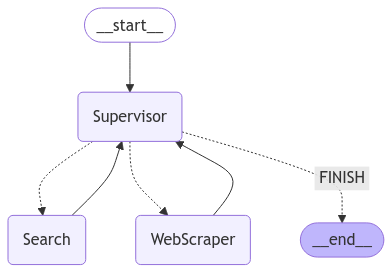

In [46]:
# plot the graph
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [47]:
# define a podcast team
class PodcastTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str
    script: List[dict]
    audio_segments: List[str]
    
podcast_plan_system = """ 
You are tasked with creating a structured script for a podcast episode.
The script should consist of a series of interactions between the host and the guest based on the provided topic and information from the research.
IMPORTANT NOTE: The podcast should have 2 or more speakers to have a conversation.

For each part of the dialoque, clearly specify whether it's the host speaking or the guest. Also, assign a suitable voice mode for text-to-speech conversion for each segment. Use the following voice models based on the character:

- Host segments: Use the 'allot' voice model.
- Guest segments: Use th 'fable' voidce model.

The output should be a list where each item is a dictionary with keys 'speaker', 'text', and 'voice', indicating the speaker (host or guest), their line of dialogue, and the voive model to use.

Example output format:
[
    {"speaker": "host", "text": "Welcome to our podcast, where we explore the latest in technology.", "voice": "alloy"},
    {"speaker": "guest", "text": "Thank you for having me, it's great to be here to share my experiences.", "voice": "fable"},
    {"speaker": "host", "text": "Can you tell us about your current project?", "voice": "alloy"},
    {"speaker": "guest", "text": "Certainly! I've been working on a new AI platform that...", "voice": "fable"},
    ...
]

Your task is to generate a similar structured script in **KOREAN**, ensuring each dialogue segment between the host and guest is well-defined and allocates the appropriate voice model for the text-to-speech conversion process.
"""

podcast_planner_agent = create_react_agent(
    llm, state_modifier=podcast_plan_system, tools=[tavily_tool]
)
podcast_planner_node = functools.partial(agent_node, agent=podcast_planner_agent, name="PodcastPlanner")

# AudioProducer agent
audio_producer_system = """ 
You are responsible for producing the final audio for the podcast episode.
Take the structured script provided by the Podcast Planner, which contains segments marked with 'speaker' (either 'host' or 'guest'), the 'text' for each segment, and the 'voice' model to use.

For each segment, use the 'text_to_speech' tool to generate audio, specifying the 'text' and 'voice' as provided.
The audio files should be combined in the order they are provided in the script, with appropriate pauses between segments to simulate a natural conversation flow.

After generating all segments, use the 'edit_podcast_audio' tool to combine these audio files into one seamless podcast episode. 
The audio files should be combined in the order they are provided in the script, with appropriate pauses between segments to simulate a natural conversation flow.

Your output should be the path to the final combined podcast episode audio file.
"""
audio_producer_agent = create_react_agent(
    llm,
    [text_to_speech, edit_podcast_audio], state_modifier=audio_producer_system
)

audio_producer_node = functools.partial(agent_node, agent=audio_producer_agent, name="AudioProducer")

# team supervisor
podcast_supervisor = create_team_supervisor(
    llm,
    """You are a supervisor tasked with managing the podcast creation process.
    Your team consists of a PodcastPlanner and an AudioProducer.
    Given the current state, decide which team member shouold act next or if the process is complete.
    Respond with 'PodcastPlanner', 'AudioProducer', or 'FINISH'.""",
    ["PodcastPlanner", "AudioProducer"]
)

In [48]:
# Podcast Team graph and chain for connecting to super layer

podcast_graph = StateGraph(PodcastTeamState)
podcast_graph.add_node("PodcastPlanner", podcast_planner_node)
podcast_graph.add_node("AudioProducer", audio_producer_node)
podcast_graph.add_node("Supervisor", podcast_supervisor)

# define control flow
podcast_graph.add_edge("PodcastPlanner", "Supervisor")
podcast_graph.add_edge("AudioProducer", "Supervisor")
podcast_graph.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {"PodcastPlanner": "PodcastPlanner", "AudioProducer": "AudioProducer", "FINISH": END},
)
podcast_graph.add_edge(START, "Supervisor")

chain = podcast_graph.compile()

# function for inter-operating podcast sub-state and super state
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_mebers": ["PodcastPlanner", "AudioProducer"],
        "next": "",
        "script": [],
        "audio_segments": []
    }
    return results

podcast_chain = enter_chain | chain


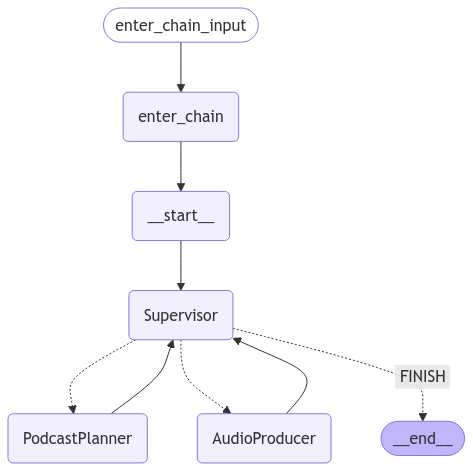

In [49]:
from IPython.display import display

display(Image(podcast_chain.get_graph().draw_mermaid_png()))

In [50]:
# define super layer supervisor
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and repsond with their results and status. When finished,"
    " respond with FINISH",
    ["ResearchTeam", "PodcastTeam"],
)

In [51]:
# build a super layer graph
# top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


# function for connecting sub layers
def get_last_message(state: State) -> str:
    return state['messages'][-1].content

def join_graph(response: dict):
    return {"messages": [response['messages'][-1]]}

# define the graph
super_graph = StateGraph(State)
# first add the node, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PodcastTeam", get_last_message | podcast_chain | join_graph
)
super_graph.add_node("Supervisor", supervisor_node)

# define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "Supervisor")
super_graph.add_edge("PodcastTeam", "Supervisor")
super_graph.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {
        "PodcastTeam": "PodcastTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "Supervisor")
super_graph = super_graph.compile()

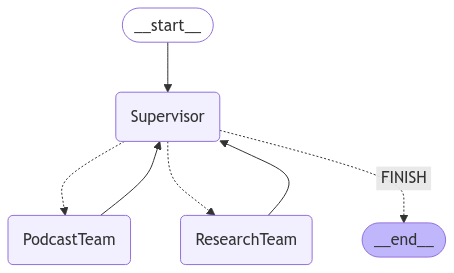

In [52]:
# plot the super graph
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [61]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="초등학생을 위한 소라게의 특징 소개"
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='소라게에 대한 정보는 다음과 같습니다:\n\n### 소라게의 특징\n1. **생물학적 분류**: 소라게는 절지동물문에 속하며, 갑각류에 해당합니다. 이들은 주로 소라껍데기와 같은 외부 껍질을 사용하여 몸을 보호합니다.\n\n2. **호흡 방식**: 소라게는 아가미를 통해 호흡하며, 육상 소라게는 공기 중의 산소를 흡수합니다. 이들은 개별적으로 껍데기를 바꿔 착용하는 특징이 있습니다.\n\n3. **서식지**: 소라게는 주로 따뜻한 해변이나 열대 지역의 숲 근처에서 발견됩니다. 이들은 육상에서 생활하며, 습기를 유지하기 위해 물이 가까운 곳에 살기를 선호합니다.\n\n4. **수명과 성장**: 소라게의 평균 수명은 약 20년입니다. 이들은 성장 과정에서 여러 번 껍데기를 갈아입으며, 새로운 껍질을 찾는 데 시간이 걸릴 수 있습니다.\n\n5. **사회적 행동**: 소라게는 사회적 동물로, 같은 종의 다른 소라게와 함께 생활하는 경향이 있습니다. 이들은 서로의 존재를 인식하고, 때때로 그룹을 이루어 행동합니다.\n\n6. **식성**: 소라게는 잡식성으로, 해조류, 과일, 나무의 껍질 등 다양한 음식을 먹습니다. 이들은 주변 환경에서 쉽게 구할 수 있는 것들을 섭취하며, 건강한 식습관을 유지하려면 다양한 음식을 제공하는 것이 중요합니다.\n\n### 교육적 가치\n- 소라게는 초등학생들에게 생물학적 다양성과 생태계의 중요성을 이해하는 데 유용한 교육 자료가 될 수 있습니다. 이들은 관찰과 실험을 통해 생명 과학에 대한 흥미를 증진시킬 수 있습니다.\n\n- 소라게의 성장 과정과 생태적 역할을 배우면서 학생들은 환경 보호의 필요성을 느낄 수 있습니다. \n\n이러한 정보는 초등학생들이 소라게에 대해 배우는 데 유용하며, 생명 과학 수업이나 자연 탐험 활동에 적합합니다.', additional_

In [54]:
super_graph.get_state

<bound method Pregel.get_state of <langgraph.graph.state.CompiledStateGraph object at 0x0000022393E1E9E0>>